In [17]:
# Copyright 2019 Eugene Maslovich
# ehpc@ehpc.io

In [18]:
import timeit
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import math
from mpmath import mp
import mpmath.libmp
from multiprocessing import Pool
%matplotlib inline
mpmath.libmp.BACKEND

'gmpy'

# Содержание

1. [Задача](#task)
1. [Алгоритм](#alrorithm)
    1. [Полностью замощённая доска](#fullboard)
    1. [Полностью пустая доска](#emptyboard)
    1. [Переходы для векторов](#transitions)
    1. [Рекурсивный алгоритм](#recursive)
    1. [Оптимизация рекурсии](#recursion-optimization)
    1. [Оптимизированный рекурсивный алгоритм](#recursion-optimized)
    1. [Переходы для векторов](#transitions)
    1. [Алгоритм переходов для векторов](#transitions-algorithm)
1. [Реализация](#code)
    1. [Анализ производительности функций ](#perf)
    1. [Работа с векторами](#code-vectors)
    1. [Рекурсивный алгоритм](#code-recursive)
    1. [Оптимизированный рекурсивный алгоритм](#code-recursive-optimized)
1. [Вычисленные числа в данной тетрадке](#computed)

# Задача <a name="task"></a>

Найти количество различных замощений $n$ прямоугольника (доски) $axb$, где $a$ - высота, $b$ - ширина, прямоугольниками $1x2$ (доминошками) с возможностью ротации на $90°$.

# Алгоритм  <a name="algorithm"></a>

Попытаемся придумать алгоритм для решения поставленной задачи.

Рассмотрим в качестве примера доску размера $a \times b = 4 \times 5$:

```
  1 2 3 4 5
 +-+-+-+-+-+
1| | | | | |
 +---------+
2| | | | | |
 +---------+
3| | | | | |
 +---------+
4| | | | | |
 +-+-+-+-+-+
```

Представим, что мы уже частично покрыли доску доминошками (здесь одинаковые буквы принадлежат одной доминошке):

```
  1 2 3 4 5
 +-+-+-+-+-+
1|A|D|D| | |
 +---------+
2|A|E|E| | |
 +---------+
3|B|B| | | |
 +---------+
4|C|C| | | |
 +-+-+-+-+-+
```

Для упрощения языка, введём понятие "**конфигурация** доски". Конфигурация доски показывает, как доска покрыта доминошками. Можно заметить, что всегда есть некоторое количество **полностью** покрытых доминошками **столбцов**. А также есть **один** столбец, покрытый частично.

Полностью покрытые столбцы можно обозначить как

$$i \in \{0, 1, 2, ..., b\}.$$

А частично покрытый столбец можно представить вектором, показывающим, какие ячейки в незаполненном столбце заполнены, а какие нет

$$v = \begin{bmatrix} v_1 \; v_2 \; \dots \; v_a \end{bmatrix}, v_x \in \{\text{входит}, \text{не входит}\}$$

Так как элементы вектора принимают всего два значения, можно использовать множество $\{0, 1\}$, где $0$ обозначает "не входит", а сам вектор представлять битовой маской. Таким образом получаем

$$v = \begin{bmatrix} v_1 \; v_2 \; \dots \; v_a \end{bmatrix}, v_x \in \{0, 1\}$$

Саму конфигурацию обозначим как

$$f(i, v).$$

Используя введённые обозначения, текущую конфигурацию доски можно записать так:

$$f(2, 1100).$$

Представим, что для конфигурации $f(2, 1100)$ нам уже известно количество возможных замощений. То есть каким-то магическим образом, мы смогли перебрать все варианты и посчитать их количество. Пусть $f$ будет функцией, которая возвращает это количество. Можем обозначить данное утверждение как

$$f(2, 1100) = k_{2,1100} \in \mathbb{N}.$$

Чтобы найти количество вариантов замощения всей доски, нам надо из текущей конфигурации перейти во все остальные возможные конфигурации. Попробуем для начала перейти в конфигурации $f(3, ?)$. Нарисуем все возможные варианты:

```
  1 2 3 4 5         1 2 3 4 5          1 2 3 4 5
 +-+-+-+-+-+       +-+-+-+-+-+        +-+-+-+-+-+
1|A|D|D| | |      1|A|D|D| | |       1|A|D|D| | |
 +---------+       +---------+        +---------+
2|A|E|E| | |      2|A|E|E| | |       2|A|E|E| | |
 +---------+  ->   +---------+  ИЛИ   +---------+
3|B|B| | | |      3|B|B|Z|Z| |       3|B|B|Y| | |
 +---------+       +---------+        +---------+
4|C|C| | | |      4|C|C|X|X| |       4|C|C|Y| | |
 +-+-+-+-+-+       +-+-+-+-+-+        +-+-+-+-+-+
```

Как видно, чтобы полностью заполнить 3-й столбец, можно либо положить две доминошки горизонтально, либо одну вертикально.

Таким образом, из $f(2, 1100)$ мы можем перейти в две конфигурации: $f(3, 0011)$ и $f(3, 0000)$.

Заметим, что $f(3, 0011) = f(3, 0000) = f(2, 1100) + 1 = k_{2,1100} + 1$. То есть, количество замощений на следующем шаге зависит от предыдущих шагов. Это означает, что задачу можно попытаться решить рекурсивно.

Но для начала рассмотрим два крайних случая: полностью замощённая доска и полностью пустая доска.

## Полностью замощённая доска <a name="fullboard"></a>

Представим, что наша доска полностью замощена. Эту конфигурацию можно записать как

$$f(5, 0000).$$

По сути это означает, что все 5 столбцов заполнены доминошками, а 6-й столбец не содержит ни одной доминошки. Понятно, что 6-го столбца на самом деле нет, но именно конфигурация $f(5, 0000)$ является единственной корректно завершающей замощение.

Если каким-то образом, мы окажемся, например в состоянии $f(5, 0011)$, то такое состояние нельзя считать успешным, так как оно соответствует следующей доске:

```
  1 2 3 4 5
 +-+-+-+-+-+
1|A|A|E|E|I|
 +---------+
2|B|D|F|H|I|
 +---------+
3|B|D|F|H|J|J
 +---------+
4|C|C|G|G|K|K
 +-+-+-+-+-+
```

То есть две доминошку выходят за пределы доски, что является некорректным.

Конфигурацию $f(b, 0)$ можно рассматривать как условие завершения рекурсии.

## Полностью пустая доска <a name="emptyboard"></a>

Представим, что наша доска пустая.

```
  1 2 3 4 5
 +-+-+-+-+-+
1| | | | | |
 +---------+
2| | | | | |
 +---------+
3| | | | | |
 +---------+
4| | | | | |
 +-+-+-+-+-+
```

Эту конфигурацию можно записать как

$$f(0, 0000).$$

Именно из этого состояния мы начинаем все попытки замощения доски. Поэтому, состояние $(f0, 0)$ можно рассматривать как начальные параметры рекурсии.

## Рекурсивный алгоритм <a name="recursive"></a>

Попробуем представить рекурсивный алгоритм. Нам уже известны два параметра, которые необходимы для передачи состояния рекурсии: $i$ и $v$, а также начальные параметры и условие завершения. На данном этапе допустим, что мы также знаем способ получения следующих состояний через векторы. Объединив все эти данные, получаем следующий алгоритм:

```python
def count_tilings(i, v):
    if i == b:       # Если мы находимся в конечном состоянии f(b, ?)
        if v == 0:   # Если конечное состояние коррректно f(b, 0)
            return 1 # Счетчик корректных замощений добавит 1 к общему числу
        else:
            return 0 # Счетчик корректных замощений получит 0, то есть не добавит ничего к общему числу
    counter = 0      # Счетчик корректных замощений, начинающихся с конфигурации f(i, v)
    for v_next in range(0, 2**a):       # Из текущего вектора мы пробуем перейти во все возможные другие вектора
        if can_go_to_v_next(v, v_next): # Если мы можем перейти из вектора v в вектор v_next
            counter += count_tilings(i + 1, v_next) # Считаем все возможные замощения из конфигурации f(i+1, v_next)
    return counter   # Возвращаем все возможные замощения из конфигурации f(i, v)

answer = count_tilings(0, 0)  # Запускаем рекурсию с начальным состоянием f(0, 0)
```

## Оптимизация рекурсии <a name="recursion-optimization"></a>

Представим следующие варианты замощения:

```
  1 2 3 4 5         1 2 3 4 5
 +-+-+-+-+-+       +-+-+-+-+-+
1|A|D|D| | |      1|A|D|D|H|H|
 +---------+       +---------+
2|A|E|E| | |      2|A|E|E|I|I|
 +---------+  ->   +---------+
3|B|B|F|F| |      3|B|B|F|F| |
 +---------+       +---------+
4|C|C|G|G| |      4|C|C|G|G| |
 +-+-+-+-+-+       +-+-+-+-+-+
 f(3, 0011)        f(4, 1100)
 
 
  1 2 3 4 5         1 2 3 4 5
 +-+-+-+-+-+       +-+-+-+-+-+
1|A|C|C| | |      1|A|C|C|H|H|
 +---------+       +---------+
2|A|D|D| | |      2|A|D|D|I|I|
 +---------+  ->   +---------+
3|B|E|F|F| |      3|B|E|F|F| |
 +---------+       +---------+
4|B|E|G|G| |      4|B|E|G|G| |
 +-+-+-+-+-+       +-+-+-+-+-+
 f(3, 0011)        f(4, 1100)
```

Можно заметить, что отличие состоит лишь в том, как расположены доминошки в нижнем левом квадранте. В первом случае они лежат горизонтально, во втором - вертикально.

Допустим, что мы получили ответ для первого варианта - количество возможных замощений из конфигурации $f(3, 0011)$ при условии горизонтального расположения доминошек в левом нижнем квадранте.

Теперь при проходе второго варианта, нам придётся снова решить ту же самую задачу - найти количество возможных замощений из конфигурации $f(3, 0011)$.

Мы можем воспользоваться этим фактом, чтобы оптимизировать рекурсивный алгоритм, сохраняя уже найденные ответы для различных конфигураций. Тем самым мы сможем избежать повторных вычислений.

Сохранять значения можно в **таблицу** размерностью $b \times 2^a$. Назовём эту таблицу $F$.

Таким образом, для примера выше, попав в первом варианте в конфигурацию $f(3, 0011)$, мы пройдем алгоритм полностью и запишем:

$$F[3, 0011_2] = k,$$

где $k$ - количество возможных замощений из конфигурации $f(3, 0011)$.

Во втором варианте, дойдя до $f(3, 0011)$, мы прекратим рекурсивные вызовы и возьмём уже готовое значение $k$ из таблицы.

# Оптимизированный рекурсивный алгоритм <a name="recursion-optimized"></a>

```python
def count_tilings_recursive_optimized(i, v):
    if i == b:       # Если мы находимся в конечном состоянии f(b, ?)
        if v == 0:   # Если конечное состояние коррректно f(b, 0)
            return 1 # Счетчик корректных замощений добавит 1 к общему числу
        else:
            return 0 # Счетчик корректных замощений получит 0, то есть не добавит ничего к общему числу
    counter = 0      # Счетчик корректных замощений, начинающихся с конфигурации f(i, v)
    for v_next in range(0, 2**a):       # Из текущего вектора мы пробуем перейти во все возможные другие вектора
        if can_go_to_v_next(v, v_next): # Если мы можем перейти из вектора v в вектор v_next
            if not F[i + 1][v_next]: # Если замощения из текущей конфигурации ещё не посчитаны
                F[i + 1][v_next] = count_tilings_recursive_optimized(i + 1, v_next) # Считаем все возможные замощения из конфигурации f(i+1, v_next) и добавляем их в таблицу
            counter += F[i + 1][v_next] # Берём готовое количество замощений из таблицы
    return counter   # Возвращаем все возможные замощения из конфигурации f(i, v)

answer = count_tilings_recursive_optimized(0, 0)  # Запускаем рекурсию с начальным состоянием f(0, 0)
```

## Переходы для векторов <a name="transitions"></a>

Остался еще один неисследованный вопрос: "Как нам узнать, в какие конфигурации мы можем перейти из текущей?".

По сути, этот вопрос сводится к вопросу: в какие вектора $v_{i+1}$ можно перейти из вектора $v_i$? Так как i + 1 у нас одно для всех.

Собственно, чтобы перейти из одного вектора в другой, должна существовать такая расстановка доминошек, после которой первый вектор стал бы полностью заполненным. При этом мы должны всегда стараться заполнить первый вектор, не пытаясь заполнить второй вектор. Это нужно, чтобы получить минимально возможное покрытие обоих векторов, что позволит не пропустить варианты.

Данные условия можно формализовать:

1. $v_i$ в итоге должен быть полностью заполнен;
1. Если $v_i[z] = 0$ и $v_i[z + 1] = 0$, то мы можем разместить доминошку либо вертикально, что даст $v_{i+1}[z] = 0$ и $v_{i+1}[z + 1] = 0$, либо две доминошки горизонтально, что даст $v_{i+1}[z] = 1$ и $v_{i+1}[z + 1] = 1$;
1. Если $v_i[z] = 0$ и $v_i[z + 1] = 1$, то мы можем разместить доминошку только горизонтально, что даст $v_{i+1}[z] = 1$ и $v_{i+1}[z + 1] = 0$;
1. Если $v_i[z] = 1$ и $v_i[z + 1] = 0$, то мы можем разместить доминошку только горизонтально, что даст $v_{i+1}[z] = 0$ и $v_{i+1}[z + 1] = 1$;
1. Если $v_i[z] = 1$ и $v_i[z + 1] = 1$, то доминошка в данные элементы вектора не влазит, что даст $v_{i+1}[z] = 0$ и $v_{i+1}[z + 1] = 0$.

## Алгоритм переходов для векторов <a name="transitions-algorithm"></a>

Зная, что вектор являет собой бинарную маску, можем свести вышеобозначенные условия к побитовым операциям над двумя числами:

```python
def can_go_to_v_next(v1, v2, height):
    if v1 & v2 == 0: # Если в v1 стоит 1, то в v2 обязательно должен быть 0, это горизонтальная доминошка
        c = 0 # Счетчик замощения нулевых битов
        v = v1 | v2 # Сливаем единицы в маске, чтобы посчитать нули
        for _ in range(0, height): # Вычленяем вектор размером height из чисел и проверяем каждый бит отдельно
            if v & 1 == 0: # Предположительно вертикальная доминошка
                c += 1 # Увеличиваем счетчик вертикального замощения
            elif c % 2 == 0: # Вертикальные замощения закончились корректно (четное количество бит)
                c = 0
            else: # Вертикальное замощение закончилось на половине доминошки
                return False
            v = v >> 1 # Переходим к следующему биту
        if c % 2 == 0: # Вертикальные замощения закончились корректно
            return True
        else:
            return False # Вертикальное замощение закончилось на половине доминошки
    else: # Некорректное горизонтальное замощение
        return False
```

# Реализация <a name="code"></a>

## Анализ производительности функций <a name="perf"></a>

In [19]:
def measure(func, args_table, n=1, pred_size=50, degree=3):
    """
    Анализирует производительность поданной на вход функции, строя график, предсказывающий производительность.
    :param func: Функция для анализа
    :param args_table: Список входящих аргументов
    :param n: Количество запусков функции
    :param pred_size: Глубина предсказания
    :param degree: Степень многочлена для аппроксимации
    """
    t = []
    # Запускаем измерения
    for args in args_table:
        t.append(timeit.timeit(lambda: func(*args), number=n) / n)
    args_x = [x[0] for x in args_table]
    
    # С DataFrame удобнее работать
    df = pd.DataFrame({'args': args_x, 't': t})
    if func.__name__ != '<lambda>':
        with open((func.__name__) + '.csv', 'a') as f:
            df.to_csv(f, mode='a', header=f.tell()==0)
    X = df[['args']]
    y = df.t
    
    # Т.к. зависимость сложная, нужна регрессия с полиномом
    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    # Обучаем линейную регрессию
    model = linear_model.LinearRegression()
    model.fit(X_poly, y)
    
    # Предсказываем
    X_pred = np.linspace(0, pred_size, pred_size*100).reshape(-1, 1)
    X_pred_poly = polynomial_features.fit_transform(X_pred)
    y_pred = model.predict(X_pred_poly)
    
    # Делаем красивой ось времени
    fig, ax = plt.subplots()
    formatter_y = matplotlib.ticker.FuncFormatter(lambda x, pos: datetime.timedelta(seconds=x))
    ax.yaxis.set_major_formatter(formatter_y)
    
    # Делаем красивой ось входящих аргументов
    delta = args_table[1][0] - args_table[0][0]
    formatter_x = matplotlib.ticker.FuncFormatter(lambda x, pos: pos)
    #ax.xaxis.set_major_formatter(formatter_x)
    
    plt.title(func.__name__)
    # Выводим входные аргументы
    plt.xlabel(str([[y for y in x if type(y) is int] for x in args_table]))
    
    # Рисуем график
    plt.scatter(args_x, t)
    plt.plot(X_pred, y_pred)

## Работа с векторами <a name="code-vectors"></a>

In [20]:
def can_go_to_v_next(v1, v2, height):
    """
    Проверяет, можно ли перейти из одного вектора v1 размерностью height в другой v1.
    :param v1: Исходный вектор
    :param v2: Предполагаемый вектор
    :param height: Размер вектора
    """
    # Исключаем ситуации, когда нет места горизонтальной доминошке
    if v1 & v2 == 0:
        c = 0
        v = v1 | v2
        # Проверяем, что есть место для вертикальных доминошек
        for _ in range(0, height):
            if v & 1 == 0:
                c += 1
            elif c % 2 == 0:
                c = 0
            else:
                return False
            v = v >> 1
        return True if c % 2 == 0 else False
    else:
        return False

Разумно заранее вычислить все возможные переходы из одного вектора в другие, чтобы сократить количество однотипных вычислений. Для этого мы составим таблицу размером $2^a \times 2^a$, где индексы будут являться числами, равными значениям векторов.

Мы можем использовать либо список, что увеличит потребление ресурсов, либо двумерный массив numpy, что будет более экономно. Преимущество списка - возможность работы за пределами оперативной памяти.

In [21]:
def precompute_v_transitions_np(a):
    """
    Заполняет таблицу возможности перехода из одних векторов в другие с помощью numpy array.
    :param a: Размер вектора
    """
    height = 2**a
    table = np.empty((height, height), dtype='?')
    for v_from in range(0, height):
        for v_to in range(0, height):
            table[v_from, v_to] = can_go_to_v_next(v_from, v_to, a)
    return table

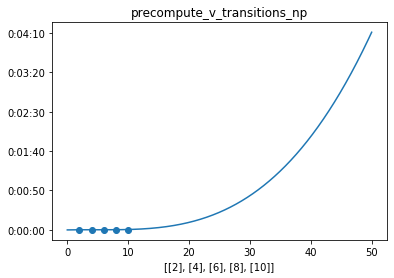

In [89]:
a = 10
measure(precompute_v_transitions_np, [[x] for x in range(2, a + 1, 2)], n=1, pred_size=50)

In [87]:
def precompute_v_transitions_list(a):
    """
    Заполняет таблицу возможности перехода из одних векторов в другие с помощью list.
    :param a: Размер вектора
    """
    height = 2**a
    return [[can_go_to_v_next(v_from, v_to, a) for v_to in range(0, height)] for v_from in range(0, height)]

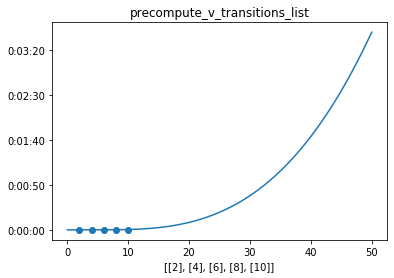

In [90]:
a = 10
measure(precompute_v_transitions_list, [[x] for x in range(2, a + 1, 2)], n=1, pred_size=50)

# Последовательность A004003

Для проверки работы алгоритма мы возьмем готовую таблицу значений из http://oeis.org/A004003.

In [40]:
seq_a004003 = ['2', '36', '6728', '12988816', '258584046368', '53060477521960000', '112202208776036178000000',
             '2444888770250892795802079170816', '548943583215388338077567813208427340288',
             '1269984011256235834242602753102293934298576249856']

## Рекурсивный алгоритм <a name="code-recursive"></a>

In [25]:
def count_tilings_recursive(a, b, i=0, v=0, transitions=None):
    """
    Рекурсивный алгоритм.
    :param a: Размер доски по вертикали
    :param b: Размер доски по горизонтали
    :param i: Количество полностью покрытых столбцов
    :param v: Вектор частично заполненного столбца
    :param transitions: Предрассчитанные переходы векторов
    
    """
    if transitions is None:
        transitions = precompute_v_transitions_np(a)
    if i == b:
        if v == 0:
            return 1
        else:
            return 0
    counter = 0
    for v_next in range(0, 2**a):
        if transitions[v, v_next]:
            counter += count_tilings_recursive(a, b, i + 1, v_next, transitions)
    return counter

a = 6
b = 6
answer = count_tilings_recursive(a, b)
print(answer)

6728


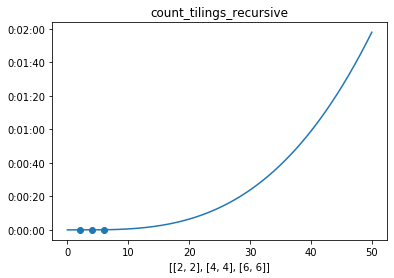

In [26]:
a = b = 6
measure(
    count_tilings_recursive,
    [[x, x] for x in range(2, a + 1, 2)],
    n=10,
    pred_size=50
)

## Оптимизированный рекурсивный алгоритм <a name="code-recursive-optimized"></a>

In [99]:
def count_tilings_recursive_optimized(a, b, i=0, v=0, iv_table=None, transitions=None, precompute_v_transitions=precompute_v_transitions_np):
    """
    Оптимизированный рекурсивный алгоритм.
    :param a: Размер доски по вертикали
    :param b: Размер доски по горизонтали
    :param i: Количество полностью покрытых столбцов
    :param v: Вектор частично заполненного столбца
    :param iv_table: Сохраненные ответы
    :param transitions: Предрассчитанные переходы векторов
    :param precompute_v_transitions: Функция предрасчета таблицы переходов
    """
    if iv_table is None:
        iv_table = [[-1 for _ in range(0, 2**a)] for i in range(0, b + 1)]
    if transitions is None:
        transitions = precompute_v_transitions(a)
    if i == b:
        if v == 0:
            return 1
        else:
            return 0
    counter = 0
    for v_next in range(0, 2**a):
        if transitions[v][v_next]:
            if iv_table[i + 1][v_next] == -1:
                iv_table[i + 1][v_next] = count_tilings_recursive_optimized(a, b, i + 1, v_next, iv_table, transitions)
            counter += iv_table[i + 1][v_next]
    return counter

a = 8
b = 8
answer = count_tilings_recursive_optimized(a, b)
print(answer)

12988816


In [94]:
def test_count_tilings_recursive_optimized():
    for index, precomputed in enumerate(seq_a004003[:5], start=1):
        a = b = index * 2
        answer = count_tilings_recursive_optimized(a, b)
        print("count_tilings_recursive_optimized({}, {}) = {}. {}.".format(
            a,
            b,
            answer,
            "PASS" if str(answer) == precomputed else "FAIL"
        ))

test_count_tilings_recursive_optimized()

count_tilings_recursive_optimized(2, 2) = 2. PASS.
count_tilings_recursive_optimized(4, 4) = 36. PASS.
count_tilings_recursive_optimized(6, 6) = 6728. PASS.
count_tilings_recursive_optimized(8, 8) = 12988816. PASS.
count_tilings_recursive_optimized(10, 10) = 258584046368. PASS.


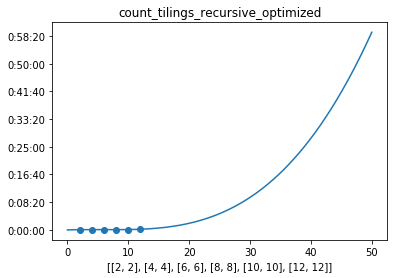

In [66]:
a = b = 12
measure(
    count_tilings_recursive_optimized,
    [[x, x] for x in range(2, a + 1, 2)],
    n=1,
    pred_size=50
)

# Вычисленные числа в данной тетрадке <a name="computed"></a>

Данные вычисления были произведены прямо в текущей тетрадке, затраченное время можно увидеть в *Wall time*.

In [61]:
%%time
count_tilings_recursive_optimized(12, 12)

Wall time: 7.69 s


53060477521960000

Для $a = b = 12$ получаем $n = 53060477521960000$.

In [71]:
%%time
count_tilings_recursive_optimized(14, 14)

Wall time: 2min 10s


112202208776036178000000

Для $a = b = 14$ получаем $n = 112202208776036178000000$.

In [73]:
%%time
count_tilings_recursive_optimized(16, 16)

Wall time: 35min 45s


2444888770250892795802079170816

Для $a = b = 16$ получаем $n = 2444888770250892795802079170816$.

In [75]:
%%time
count_tilings_recursive_optimized(17, 18)

Wall time: 2h 25min 40s


3023972648453090098847701387683202369

Для $a = 17, b = 18$ получаем $n = 3023972648453090098847701387683202369$.

In [101]:
%%time
count_tilings_recursive_optimized(15, 30)

Wall time: 23min 45s


923928802526649277978986699734118237839301236744758561

Для $a = 15, b = 30$ получаем $n = 923928802526649277978986699734118237839301236744758561$.

In [103]:
%%time
count_tilings_recursive_optimized(15, 60)

Wall time: 46min 2s


6161980077253528077935036258159799807001056897362244183716344604115730310552059430381432666396939141778344731

Для $a = 15, b = 60$ получаем $n = 6161980077253528077935036258159799807001056897362244183716344604115730310552059430381432666396939141778344731$.

In [104]:
%%time
count_tilings_recursive_optimized(15, 120)

Wall time: 1h 28min 32s


274087410487651644890503453398936105844296709708243041850099877547358645899534187744929239863538441564174711709017699161711953479125554298678537228862424174427565357081911841467197908444634080796987929939976622199566217

Для $a = 15, b = 120$ получаем $n = 274087410487651644890503453398936105844296709708243041850099877547358645899534187744929239863538441564174711709017699161711953479125554298678537228862424174427565357081911841467197908444634080796987929939976622199566217$.

In [106]:
%%time
count_tilings_recursive_optimized(15, 1600)

Wall time: 18h 37min 6s


1237996559217934097846212955991936859864025153285469930379572951904224356583087860343972134250130562848368729104548011583670734376998895416332222667576065041829240377108171589118340342012751909876288897827492216384267348429183988357763216666710192265072745393107422642332435361800633947585505250590346781032761069727400809700332434476814979099391499200564712108218902889186235719085808535721113626562644379672762794998816268417614286951561671401448951198235034781662154031170718230403944905916586603146899020150403953740826980098228191845763862667087132477888299763626110163715593746638027476110113304856482836705848333352445515471517027427321858657219436880104799777128673214677808594158081006272611904148366004250760957507470652542124242325632444062352036219744988144493921887321592332011655608908095486152515047624731012277106145619011207488580749911141616482426021752834222487749135094764654522558344683319562049588985474838944770745540874609996136561163912530849848814370315867146103815482271251

Для $a = 15, b = 1600$ получаем $n = 12379965592179340978462129559919368598640251532854699303795729519042243565830878603439721342501305628483687291045480115836707343769988954163322226675760650418292403771081715891183403420127519098762888978274922163842673484291839883577632166667101922650727453931074226423324353618006339475855052505903467810327610697274008097003324344768149790993914992005647121082189028891862357190858085357211136265626443796727627949988162684176142869515616714014489511982350347816621540311707182304039449059165866031468990201504039537408269800982281918457638626670871324778882997636261101637155937466380274761101133048564828367058483333524455154715170274273218586572194368801047997771286732146778085941580810062726119041483660042507609575074706525421242423256324440623520362197449881444939218873215923320116556089080954861525150476247310122771061456190112074885807499111416164824260217528342224877491350947646545225583446833195620495889854748389447707455408746099961365611639125308498488143703158671461038154822712518441885856625415874160219665590609596167844773659052394980579265092852885233959002446555716328225781554733382284665467235525737791834929652633108699205336318573796879673579042387165815831449778656309701562778456288128583270057443617545363147907948552297535846309827517071986826391372862977055762980454806128523216918055404738431614416678106694227967105955130726691793603925050731127831836419719894879256277426277479223601232965085812637274356036167011672616790446625310631954378349304782805583286318838870090155603258508450250431896287053535300683718678274734780373416636006527233611473506352544441552065871291516087757337466453241779264247299539828211543420516415494975893636264229505063572552243893774604277717969164690011325083508249221126654046080949710400087625789196331420849923494317453048187710148280520952767215730685103288856895449055105865770488398550192000433769279691598632157243790284991681955454182312854041901875310450409900774655551219648525228438328521706001919983153758199996338106586852457181619987326914602632064043310002901992724405394194516681611979844965283658625585690883897395533420309076513657890053651546981598694275678079189080026898314048473456183740955506699374196303913851063068529937508428283406870287025704498315264678941102188751891700438455788012275752732951495187669185391131907394872905018361566323697650164160914791146061643277516708983663183859955117767408271611027161035675073836095317198797932123499599787610325712814270137694290173815698453442678287884822705331075682719698274917142381142502676466111202409237973694149590220651329356159485384715361146037526877837153388975793950963953718279315941200333782682865994676149847232275160574874425068396372173833112004661457349914451177403394756774821710749115036204892920026254752374911392706986169247115294178754617662770706363589367087455944560520106693509009954497854637234434726861077414249546704087621931421339886562316570587202497$.